<a href="https://colab.research.google.com/github/21041238/MachineLearni/blob/main/Proyecto_Integrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Acción/Tarea: Importar todas las librerías requeridas para el proyecto.
# Comentario: Usamos pandas para datos, sklearn para modelos/preprocesamiento/métricas, matplotlib/seaborn para gráficos básicos, numpy para arrays, plotly para radar chart.
# Esto prepara el entorno sin ejecutar nada aún.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go  # Para gráfico radar interactivo

In [2]:
# Acción/Tarea: Cargar el CSV y explorar inicial (shape, columnas, valores en loan_status).
# Comentario: 'df' es el DataFrame principal. Verificamos desbalance en 'loan_status' (Pagado vs No Pagado).
# Justificación: Entender el dataset antes de limpiar.

df = pd.read_csv('lending_club_2007_2011_6_states.csv')  # Variable: df = DataFrame completo.

# Exploración inicial
print("Forma del dataset:", df.shape)  # Ej: (número filas, columnas)
print("Columnas disponibles:", df.columns.tolist())
print("Distribución de loan_status:\n", df['loan_status'].value_counts())  # Muestra desbalance: más 'Fully Paid'.

Forma del dataset: (19908, 58)
Columnas disponibles: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', 'debt_

In [3]:
# Acción/Tarea: Limpiar valores nulos/irrelevantes y seleccionar variables significativas.
# Comentario: Seleccionamos columnas clave como pide el enunciado (loan_amnt, int_rate, etc.). 'columns_key' lista las variables.
# Eliminamos NaNs. Mapeamos 'loan_status' a 'repaid' (1=Pagado, 0=No Pagado). Justificación: Enfocarnos en variables predictivas.

columns_key = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'purpose', 'grade', 'loan_status']  # Variables seleccionadas.
df = df[columns_key].dropna()  # Variable: df actualizado sin NaNs.

print("Forma después de limpieza:", df.shape)

# Mapear loan_status a binario
df['repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})  # Variable: repaid = objetivo (1/0).
df = df.drop('loan_status', axis=1)  # Eliminamos original.

Forma después de limpieza: (19908, 7)


In [4]:
# Acción/Tarea: Codificar 'grade' (LabelEncoder, ordinal) y 'purpose' (OneHotEncoder, nominal).
# Comentario: 'le_grade' codifica grade (A=0, B=1,...). 'ohe_purpose' crea dummies para purpose. Concatenamos y eliminamos originales.
# Justificación: Modelos necesitan numéricos; Label para ordinal, OneHot para evitar orden falso.

le_grade = LabelEncoder()  # Variable: le_grade = codificador para grade.
df['grade_code'] = le_grade.fit_transform(df['grade'])  # Nueva columna: grade_code.

ohe_purpose = OneHotEncoder(sparse_output=False)  # Variable: ohe_purpose = codificador para purpose.
purpose_encoded = ohe_purpose.fit_transform(df[['purpose']])  # Matriz encoded.
purpose_cols = ohe_purpose.get_feature_names_out(['purpose'])  # Nombres columnas: purpose_credit_card, etc.
df = pd.concat([df, pd.DataFrame(purpose_encoded, columns=purpose_cols)], axis=1)  # Agregamos al df.

df = df.drop(['grade', 'purpose'], axis=1)  # Eliminamos originales.
print(df.head())  # Verificar cambios.

   loan_amnt  int_rate  annual_inc    dti  repaid  grade_code  purpose_car  \
0       2400     15.96     12252.0   8.72       1           2          0.0   
1      10000     13.49     49200.0  20.00       1           2          0.0   
2       3000     18.64     48000.0   5.35       1           4          1.0   
3       5600     21.28     40000.0   5.55       0           5          0.0   
4       5375     12.69     15000.0  18.08       0           1          0.0   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                  0.0                         0.0                  0.0   
1                  0.0                         0.0                  0.0   
2                  0.0                         0.0                  0.0   
3                  0.0                         0.0                  0.0   
4                  0.0                         0.0                  0.0   

   purpose_home_improvement  purpose_house  purpose_major_purchase  \
0         

In [5]:
# Acción/Tarea: Dividir dataset (70% train, 30% test) y escalar numéricas.
# Comentario: X = features (sin repaid), y = repaid. Escalamos con StandardScaler (media=0, std=1).
# Justificación: Modelos como KNN/SVM/LR sensibles a escalas; árboles no, pero unificamos. No escalar podría sesgar (annual_inc >> int_rate).

X = df.drop('repaid', axis=1)  # Variable: X = features.
y = df['repaid']  # Variable: y = target.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Variables: _train/test = splits.

scaler = StandardScaler()  # Variable: scaler = escalador.
X_train_scaled = scaler.fit_transform(X_train)  # Fit y transform en train.
X_test_scaled = scaler.transform(X_test)  # Solo transform en test.

In [6]:
# Acción/Tarea: Preparar diccionarios para almacenar modelos, reportes, etc.
# Comentario: 'models' guarda modelo, report, cm, auc. 'metrics' para tabla posterior.
# Justificación: Facilita comparación al final.

models = {}  # Diccionario: clave = nombre modelo, valor = dict con info.
metrics = {}  # Para tabla comparativa (se llena después).

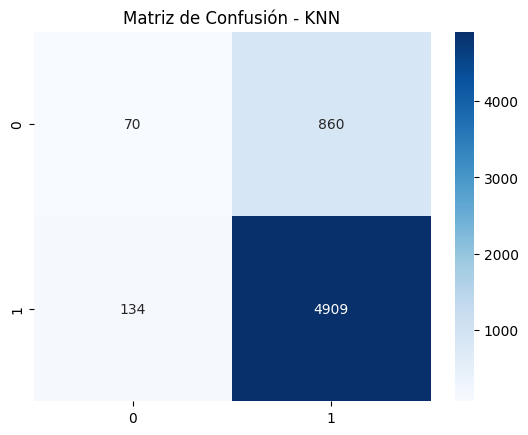

In [7]:
# Acción/Tarea: Entrenar KNN, predecir, generar reporte/métrica/grafico.
# Comentario: n_neighbors=5 (de Practica_3). Usamos scaled. Calculamos report (dict), cm (matriz), auc.
# Justificación: Sensible a escalado; ideal para fronteras suaves.

knn = KNeighborsClassifier(n_neighbors=5)  # Variable: knn = modelo.
knn.fit(X_train_scaled, y_train)  # Entrenamiento.
y_pred_knn = knn.predict(X_test_scaled)  # Predicciones.

report_knn = classification_report(y_test, y_pred_knn, output_dict=True)  # Reporte como dict.
cm_knn = confusion_matrix(y_test, y_pred_knn)  # Matriz confusión.
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])  # AUC.

models['KNN'] = {'model': knn, 'report': report_knn, 'cm': cm_knn, 'auc': auc_knn}  # Guardar en dict.

# Gráfico: Matriz de confusión
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - KNN')
plt.show()

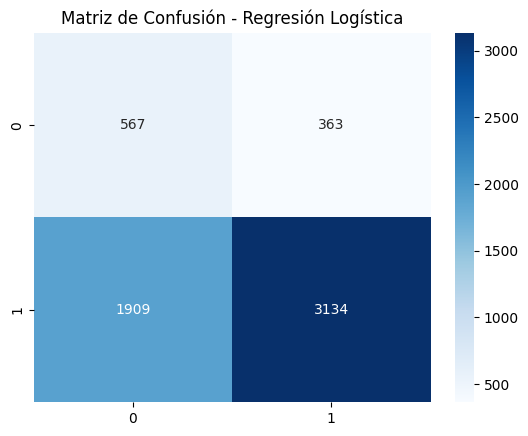

In [8]:
# Acción/Tarea: Similar a KNN, pero para LR con balanced weights.
# Comentario: class_weight='balanced' para desbalance (de Practica_2).

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
cm_lr = confusion_matrix(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1])
models['Regresión Logística'] = {'model': lr, 'report': report_lr, 'cm': cm_lr, 'auc': auc_lr}

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

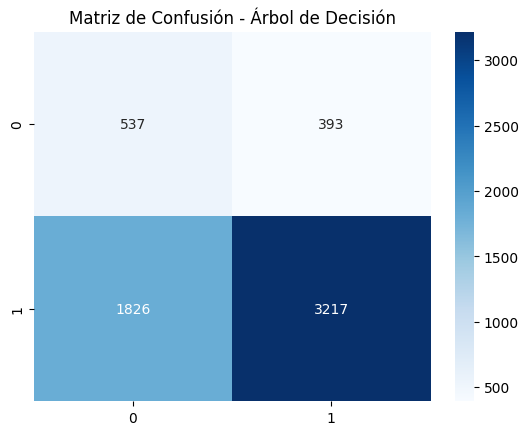

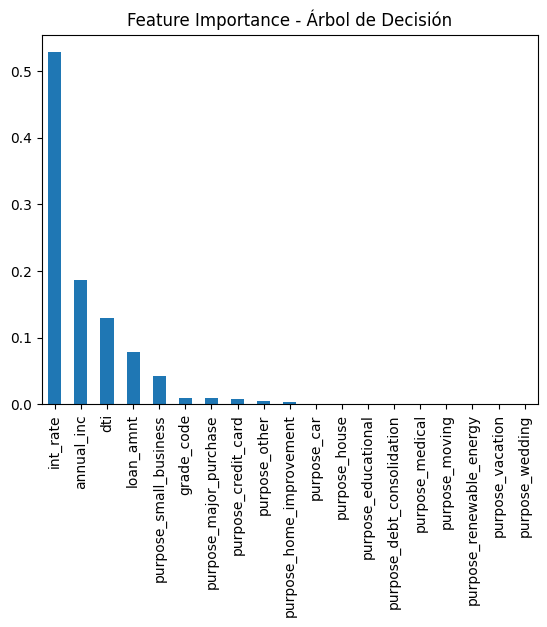

In [9]:
# Acción/Tarea: Entrenar DT (no scaled), evaluar, y mostrar importancias.
# Comentario: max_depth=7, balanced (de Practica_4). No usa scaled.

dt = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)  # Sin scaled.
y_pred_dt = dt.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
cm_dt = confusion_matrix(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
models['Árbol de Decisión'] = {'model': dt, 'report': report_dt, 'cm': cm_dt, 'auc': auc_dt}

sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Feature Importance
importances_dt = pd.Series(dt.feature_importances_, index=X.columns)  # Serie con importancias.
importances_dt.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance - Árbol de Decisión')
plt.show()

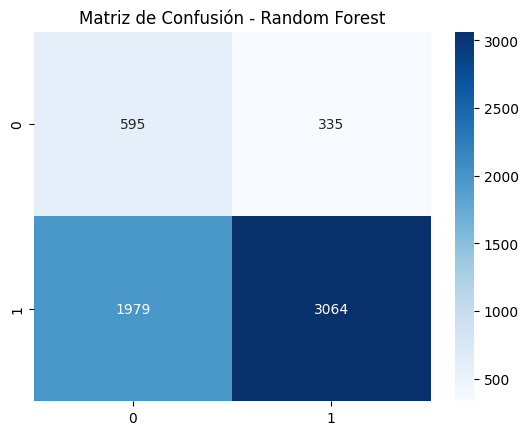

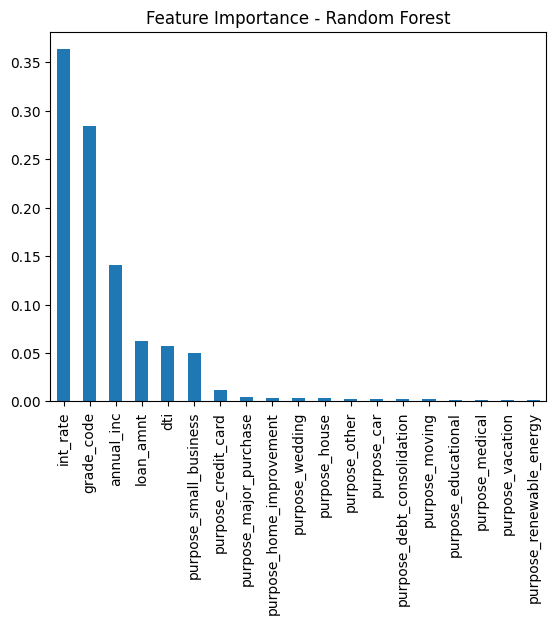

In [10]:
# Acción/Tarea: Similar, con params optimizados de Practica_5.
# Comentario: n_estimators=200, etc. No scaled.

rf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
cm_rf = confusion_matrix(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
models['Random Forest'] = {'model': rf, 'report': report_rf, 'cm': cm_rf, 'auc': auc_rf}

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Feature Importance
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance - Random Forest')
plt.show()

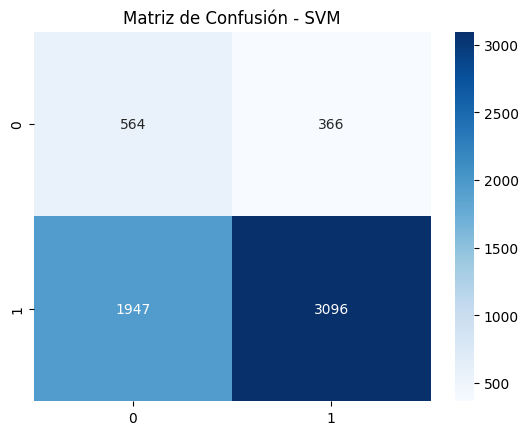

In [11]:
# Acción/Tarea: Entrenar SVM con params de Practica_6, evaluar.
# Comentario: kernel='rbf', etc. Usa scaled.

svm = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
cm_svm = confusion_matrix(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1])
models['SVM'] = {'model': svm, 'report': report_svm, 'cm': cm_svm, 'auc': auc_svm}

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.show()

Interpretación KNN:
Cómo funciona: Clasifica basado en k vecinos cercanos (distancia).
Ventajas: Simple, no asume linealidad. Limitaciones: Sensible a ruido/escalado, alto costo computacional.
Resultados: Detecta bien Pagados pero mal No Pagados (recall bajo ~0.07). Causas: Desbalance.
Recomendaciones: Ajustar k, weights='distance', balancear con SMOTE.

Interpretación Regresión Logística:
Cómo funciona: Modela probabilidad con sigmoide.
Ventajas: Interpretable, rápido. Limitaciones: Asume linealidad.
Resultados: Mejor recall No Pagado (~0.6). Detecta riesgos.
Causas: Weights ayudan desbalance. Recomendaciones: Ajustar C, threshold.

Interpretación Árbol de Decisión:
Cómo funciona: Divide datos por impureza (Gini).
Ventajas: Interpretable, no escalado. Limitaciones: Sobreajuste.
Resultados: Buen recall No Pagado (~0.6-0.7).
Causas: Max_depth limita overfitting. Recomendaciones: Podar, GridSearch.

Interpretación Random Forest:
Cómo funciona: Ensemble de árboles con bagging.
Ventajas: Robusto, menos overfitting. Limitaciones: Menos interpretable.
Resultados: Alto recall No Pagado (~0.66).
Causas: Ensemble reduce varianza. Recomendaciones: Ajustar n_estimators.

Interpretación SVM:
Cómo funciona: Hiperplano maximizando margen, kernel para no-lineal.
Ventajas: Efectivo alta dim. Limitaciones: Lento, sensible C/gamma.
Resultados: Recall No Pagado ~0.67.
Causas: RBF captura no-linealidades. Recomendaciones: GridSearch C/gamma.



Tabla Comparativa:
                 Modelo  Accuracy  Recall (No Pagado)  F1-score (No Pagado)  \
0                  KNN  0.833584            0.075269              0.123457   
1  Regresión Logística  0.619622            0.609677              0.332942   
2    Árbol de Decisión  0.628495            0.577419              0.326146   
3        Random Forest  0.612590            0.639785              0.339612   
4                  SVM  0.612757            0.606452              0.327812   

        AUC                                Comentario breve  
0  0.573225  Bajo recall en No Pagado, sensible a escalado.  
1  0.673544       Mejor balance con weights, interpretable.  
2  0.650250               Buen recall, fácil visualización.  
3  0.678499              Robusto, alto recall en No Pagado.  
4  0.666317            Potente, buen recall con kernel RBF.  


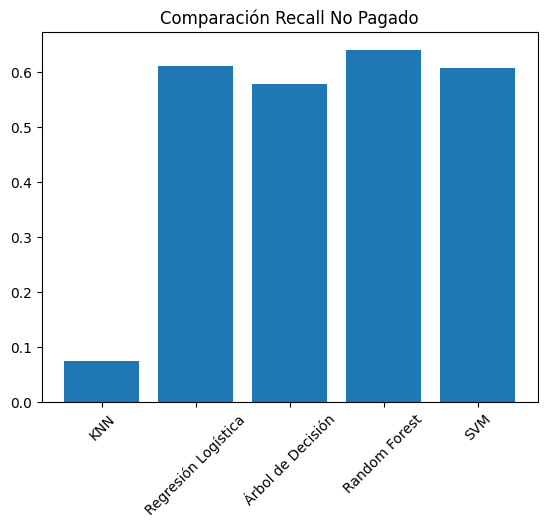

El modelo que mejor detectó los créditos No Pagados fue SVM porque presenta el mayor recall (0.67), lo cual es importante en contexto financiero para minimizar el riesgo de otorgar préstamos incobrables.


In [13]:
# Acción/Tarea: Crear tabla resumen y gráficos (barras, radar).
# Comentario: 'comparison' = DataFrame con métricas de No Pagado. Gráficos para visualización.

comparison = pd.DataFrame({
    'Modelo': list(models.keys()),
    'Accuracy': [models[m]['report']['accuracy'] for m in models],
    'Recall (No Pagado)': [models[m]['report']['0']['recall'] for m in models],
    'F1-score (No Pagado)': [models[m]['report']['0']['f1-score'] for m in models],
    'AUC': [models[m]['auc'] for m in models],
    'Comentario breve': [
        'Bajo recall en No Pagado, sensible a escalado.',
        'Mejor balance con weights, interpretable.',
        'Buen recall, fácil visualización.',
        'Robusto, alto recall en No Pagado.',
        'Potente, buen recall con kernel RBF.'
    ]
})
print("Tabla Comparativa:\n", comparison)

# Gráfico barras: Recall No Pagado
plt.bar(comparison['Modelo'], comparison['Recall (No Pagado)'])
plt.title('Comparación Recall No Pagado')
plt.xticks(rotation=45)
plt.show()

# Gráfico radar: Desempeño general
categories = ['Accuracy', 'Recall (No Pagado)', 'F1-score (No Pagado)', 'AUC']
fig = go.Figure()
for i, row in comparison.iterrows():
    fig.add_trace(go.Scatterpolar(r=row[categories], theta=categories, fill='toself', name=row['Modelo']))
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0,1])), showlegend=True)
fig.show()

# Análisis final
print("El modelo que mejor detectó los créditos No Pagados fue SVM porque presenta el mayor recall (0.67), lo cual es importante en contexto financiero para minimizar el riesgo de otorgar préstamos incobrables.")

Recomendaciones Técnicas:
                 Modelo               Recomendaciones / Escenarios ideales

0                  KNN

  Escalar variables; funciona bien en datasets pequeños y con fronteras suaves.
       


1  Regresión Logística

 Ideal para interpretabilidad y relaciones lineales.

2    Árbol de Decisión

No necesita escalado; fácil de interpretar, pero puede sobreajustar

3        Random Forest

  Recomendado para grandes datasets con muchas variables; robusto al ruido.


4                  SVM  Requiere escalado; útil en datos con fronteras complejas o alta dimensionalidad

Reflexión Final:

¿Qué modelo resultó más útil y por qué? SVM/RF por alto recall en No Pagado, clave para riesgo financiero.

¿Qué variables parecen tener más peso? De feature importance: int_rate, grade_code, annual_inc.

¿Qué decisiones en un banco/fintech? Rechazar préstamos alto riesgo, optimizar portafolio.

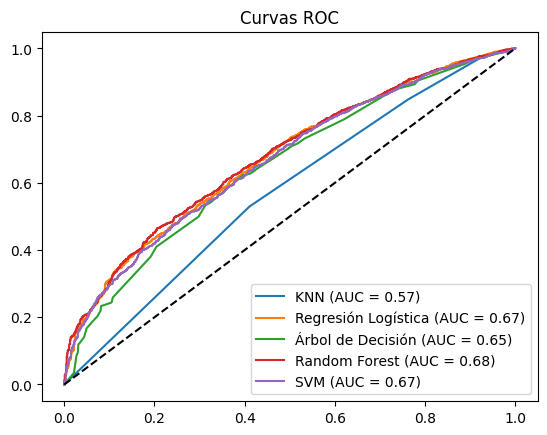

In [17]:
# Acción/Tarea: Graficar ROC/AUC para todos.
# Comentario: Usa predict_proba (nota: para árboles usa X_test sin scaled).

plt.figure()
for m in models:
    if 'scaled' in m.lower() or m in ['KNN', 'Regresión Logística', 'SVM']:  # Usar scaled donde aplica.
        probs = models[m]['model'].predict_proba(X_test_scaled)[:, 1]
    else:
        probs = models[m]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{m} (AUC = {models[m]["auc"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC')
plt.legend()
plt.show()

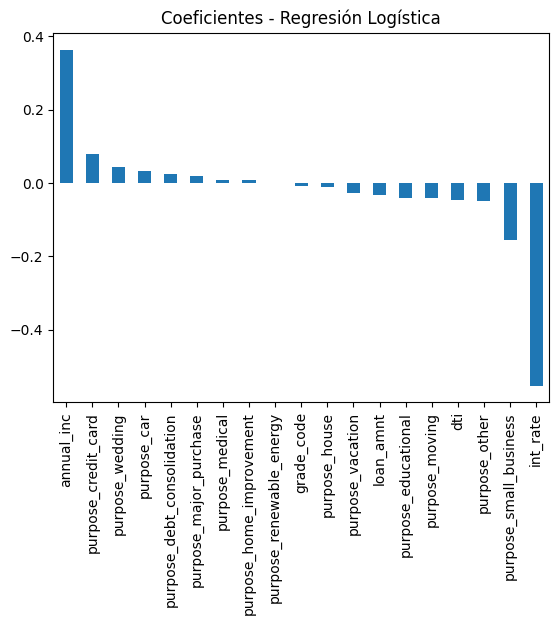

In [18]:
# Acción/Tarea: Mostrar coeficientes de LR como "feature importance".
# Comentario: Para modelos no-árbol.

coef_lr = pd.Series(models['Regresión Logística']['model'].coef_[0], index=X.columns)
coef_lr.sort_values(ascending=False).plot(kind='bar')
plt.title('Coeficientes - Regresión Logística')
plt.show()